# SaaS Retention Analytics
## Notebook 02 — Exploratory Analysis & Visualization

This notebook analyzes customer churn patterns and identifies high-risk segments.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

customer_features = pd.read_csv("../data/processed/customer_features.csv")

customer_features.head()

,customer_id,name,email,signup_date,country,plan_type,subscription_status,subscription_start,last_payment_date,total_revenue,num_transactions,last_login_date,total_logins,days_since_payment,days_since_login,financial_churn,engagement_churn,silent_churn,active
0,1,Tara Ramos,pinedajill@gmail.com,2025-02-09,Bermuda,Basic,Active,2023-12-12,2024-10-11,810.32,10.0,2024-02-02,10.0,149.0,401.0,True,True,False,False
1,2,Casey Sanders,kimberly26@white-velasquez.biz,2022-10-11,Lao People's Democratic Republic,NaN,NaN,NaN,2024-08-19,1075.64,9.0,2024-05-28,10.0,202.0,285.0,True,True,False,False
2,3,Amanda Fernandez,annapugh@wiggins.biz,2023-04-19,Sweden,NaN,NaN,NaN,2025-02-06,558.47,7.0,2025-02-21,8.0,31.0,16.0,False,False,False,True
3,4,Manuel Atkins,webbdavid@hotmail.com,2024-05-05,Costa Rica,Premium,Canceled,2022-05-09,2024-12-21,671.55,8.0,2024-03-19,2.0,78.0,355.0,False,True,True,False
4,5,Mark Jennings,austin86@hotmail.com,2023-12-25,French Guiana,Basic,Active,2024-01-28,2024-04-06,325.84,5.0,2024-03-01,5.0,337.0,373.0,True,True,False,False


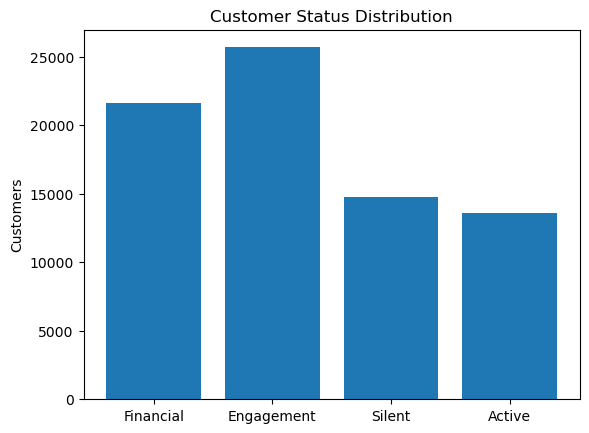

In [25]:
labels = ["Financial", "Engagement", "Silent", "Active"]
values = [
    customer_features["financial_churn"].sum(),
    customer_features["engagement_churn"].sum(),
    customer_features["silent_churn"].sum(),
    customer_features["active"].sum()
]

plt.figure()
plt.bar(labels, values)
plt.title("Customer Status Distribution")
plt.ylabel("Customers")
plt.show()

In [26]:
plan_churn = (
    customer_features
    .groupby("plan_type", as_index=False)
    .agg(
        customers=("customer_id","count"),
        financial_churn_rate=("financial_churn","mean"),
        avg_revenue=("total_revenue","mean")
    )
    .sort_values("financial_churn_rate", ascending=False)
)

plan_churn

,plan_type,customers,financial_churn_rate,avg_revenue
1,Premium,8536,0.438261,1028.304377
2,Standard,12983,0.434876,1029.237778
0,Basic,21662,0.431216,1029.028411


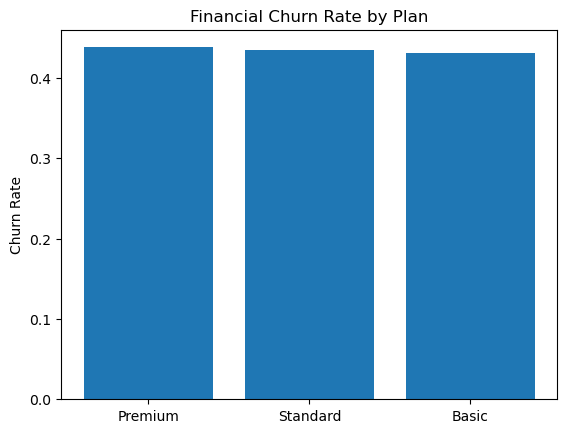

In [27]:
plt.figure()

plt.bar(plan_churn["plan_type"], plan_churn["financial_churn_rate"])
plt.title("Financial Churn Rate by Plan")
plt.ylabel("Churn Rate")

plt.savefig("../images/churn_by_plan.png", bbox_inches="tight")

plt.show()

In [28]:
country_churn = (
    customer_features
    .groupby("country", as_index=False)
    .agg(
        customers=("customer_id","count"),
        financial_churn_rate=("financial_churn","mean")
    )
    .sort_values("financial_churn_rate", ascending=False)
)

country_churn.head(10)

,country,customers,financial_churn_rate
13,Austria,205,0.526829
71,Finland,217,0.511521
242,Zimbabwe,177,0.502825
166,Palestinian Territory,209,0.492823
18,Barbados,191,0.486911
192,Senegal,185,0.486486
21,Belize,208,0.485577
111,Kazakhstan,233,0.484979
159,Niue,192,0.484375
196,Singapore,190,0.484211


In [29]:
customer_features["signup_month"] = pd.to_datetime(
    customer_features["signup_date"]
).dt.to_period("M").astype(str)

In [30]:
cohort_churn = (
    customer_features
    .groupby("signup_month", as_index=False)
    .agg(
        customers=("customer_id","count"),
        financial_churn_rate=("financial_churn","mean")
    )
    .sort_values("signup_month")
)

cohort_churn.tail(12)

,signup_month,customers,financial_churn_rate
25,2024-04,1337,0.443530
26,2024-05,1420,0.435915
27,2024-06,1382,0.426194
28,2024-07,1434,0.413529
29,2024-08,1426,0.420757
30,2024-09,1372,0.436589
31,2024-10,1425,0.435088
32,2024-11,1413,0.423213
33,2024-12,1449,0.425811
34,2025-01,1417,0.413550


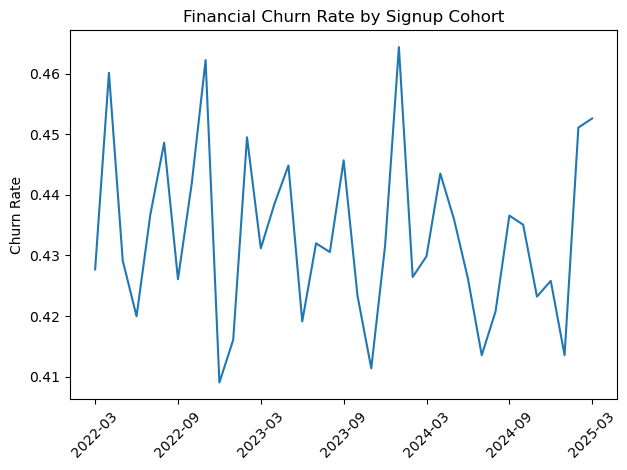

In [31]:
plt.figure()

plt.plot(cohort_churn["signup_month"], cohort_churn["financial_churn_rate"])

plt.xticks(
    ticks=range(0, len(cohort_churn), 6),
    labels=cohort_churn["signup_month"][::6],
    rotation=45
)

plt.title("Financial Churn Rate by Signup Cohort")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()

## Revenue Impact of Churn

This section estimates the total revenue associated with customers who have financially churned.
Understanding this number helps quantify the business impact of retention challenges.

Total revenue lost to churn: $20,391,657.29


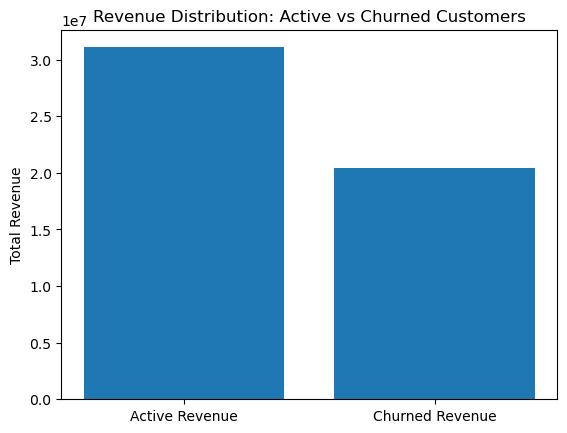

In [32]:
revenue_lost = customer_features.loc[
    customer_features["financial_churn"] == True,
    "total_revenue"
].sum()

print(f"Total revenue lost to churn: ${revenue_lost:,.2f}")

active_revenue = customer_features.loc[
    customer_features["financial_churn"] == False,
    "total_revenue"
].sum()

plt.figure()
plt.bar(["Active Revenue", "Churned Revenue"], [active_revenue, revenue_lost])
plt.title("Revenue Distribution: Active vs Churned Customers")
plt.ylabel("Total Revenue")
plt.show()

In [33]:
at_risk = customer_features[
    customer_features["silent_churn"] == True
][[
    "customer_id",
    "name",
    "plan_type",
    "country",
    "days_since_login",
    "total_revenue"
]].sort_values("total_revenue", ascending=False)

print(f"Number of at-risk customers: {len(at_risk):,}")
at_risk.head(20)

Number of at-risk customers: 14,729


,customer_id,name,plan_type,country,days_since_login,total_revenue
11749,11750,Melinda Moore,Basic,Montserrat,260.0,2907.00
557,558,Herbert Norman,Premium,Russian Federation,479.0,2743.31
16489,16490,Catherine Carney,Standard,Switzerland,331.0,2701.88
12354,12355,Mr. Brett Hogan,Basic,Pitcairn Islands,298.0,2658.99
37225,37226,Ana Reyes,Basic,French Guiana,209.0,2630.15
40562,40563,Tina Smith,Basic,American Samoa,146.0,2612.79
16342,16343,Robert Olson,Standard,Mali,330.0,2608.94
40948,40949,Lucas Simon,Premium,Montserrat,177.0,2588.26
46862,46863,Michael Anderson,NaN,Latvia,131.0,2585.20
45880,45881,Chelsea Perez,Basic,Switzerland,143.0,2577.73


In [34]:
import os

os.makedirs("../exports", exist_ok=True)

at_risk.to_csv("../exports/at_risk_customers.csv", index=False)
print("Saved to ../exports/at_risk_customers.csv")

Saved to ../exports/at_risk_customers.csv


In [35]:
os.listdir("../exports")

['at_risk_customers.csv']

## Executive Summary

### What we found
- Overall financial churn is high (~43%).
- Churn is similar across plan tiers, suggesting pricing is not the main driver.
- Cohort analysis shows churn is relatively stable across signup periods.
- A significant number of customers are in silent churn (paying but inactive).

### Business Impact
- Silent churn represents potential revenue loss and reduced long-term retention.
- High churn rates suggest onboarding, engagement, or product value may need improvement.

### Recommendations
1. Trigger outreach for customers inactive for 30+ days.
2. Improve onboarding to increase early engagement.
3. Monitor silent churn customers and target them with re-engagement campaigns.